In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

# 데이터 불러오기

-> 데이터 설명 : 24시간 생활심전도를 모니터링 하는것인데, 소형 심전도 기계를 몸에 부착하여 24시간을 부착하는 방식으로 사용된다.

-> 변수의 개수 : 187개 

-> Train_Data의 개수 : 87554

-> Test_Data의 개수 : 21892

-> 총 클래스는 5개가 존재하며 0인 클래스는 Normal로 나머지 클래스는 Abnormal로 설정했다.

해당 코드 구현은 

시계열데이터를 GramianAngularField을 사용하여 이미지로 변환하여 Anomaly를 탐지하였다.

Train_Data는 GramianAngularField를 학습하기 위한 용도로 활용되었으며

Test_Data를 8:2로 Split하여 Convolution Autoencoder를 정상로만 데이터로 학습하고 테스트 했다.





In [217]:
# GramianAngularField를 학습하기 위한 데이터 셋
df_hb_train = pd.read_csv('C:/Users/2022010560/Desktop/Dataset/mitbih_train.csv', header=None)

# Autoencoder를 학습 및 Test하기 위한 데이터 셋
df_hb_test = pd.read_csv('C:/Users/2022010560/Desktop/Dataset/mitbih_test.csv', header=None)

In [218]:
df_hb_train.shape

(87554, 188)

In [219]:
df_hb_test.shape

(21892, 188)

In [220]:
df_hb_train.iloc[:,-1].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

# GramianAngularField

In [221]:
# GramianAngularField를 학습하기 위한 데이터 셋

x_train = df_hb_train.iloc[:,:187]

In [234]:
gasf = GramianAngularField(image_size=187, method='summation')
x_gasf_train = gasf.fit_transform(x_train)

In [235]:
# 이미지변환 했을 때 차원
x_gasf_train[0].shape

(187, 187)

# Conv Autoencoder

In [223]:
# HyperParmeter
args = {
	'BATCH_SIZE': 256,
        'LEARNING_RATE': 0.005,
        'NUM_EPOCH': 30
        }

In [224]:

# Autoencoder를 학습하기 위한 데이터 셋 
# Normal Train & Normal Test Dataset  8:2 로 분리

x_train_normal = df_hb_test.loc[df_hb_test.iloc[:,-1]==0].iloc[:,:187][:int(len(df_hb_test.loc[df_hb_test.iloc[:,-1]==0])*0.8)]
x_test_normal = df_hb_test.loc[df_hb_test.iloc[:,-1]==0].iloc[:,:187][int(len(df_hb_test.loc[df_hb_test.iloc[:,-1]==0])*0.8):]

In [225]:

#Label 

y_train_normal_label = df_hb_test.loc[df_hb_test.iloc[:,-1]==0].iloc[:,187].values[:int(len(df_hb_test.loc[df_hb_test.iloc[:,-1]==0])*0.8)]
y_test_normal_label = df_hb_test.loc[df_hb_test.iloc[:,-1]==0].iloc[:,-1].values[int(len(df_hb_test.loc[df_hb_test.iloc[:,-1]==0])*0.8):]

In [226]:
len(y_train_normal_label)

14494

In [227]:

# Autoencoder를 Test 하기 위한 Abnormal Dataset

x_test_abnormal = df_hb_test.loc[df_hb_test.iloc[:,-1]!=0].iloc[:,:187]
y_test_abnormal_label = df_hb_test.loc[df_hb_test.iloc[:,-1]!=0].iloc[:,-1].values

In [228]:
len(y_test_abnormal_label)

3774

In [229]:
# Gasf Dataset Class로 정의
class gasf_Dataset(Dataset):
    def __init__(self,images,labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
        print(f'데이터_사이즈:{len(self.images)}')
        
    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        label = self.labels[idx]
        return image.type(torch.float32), label
    
    def __len__(self):
        return len(self.images)
    
    
def Resize_go(ver):
    if ver ==1 :
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize(mean=[0.5], std=[0.5])]) # Mormalization은 고민
        
    if ver ==2:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])])
        
    return transform

In [230]:


train_dataset = gasf_Dataset(x_train_normal,y_train_normal_label,Resize_go(1))
test_normal_dataset = gasf_Dataset(x_test_normal,y_test_normal_label ,Resize_go(1))
test_abnormal_dataset = gasf_Dataset(x_test_abnormal,y_test_abnormal_label ,Resize_go(1))

데이터_사이즈:14494
데이터_사이즈:3624
데이터_사이즈:3774


In [121]:
train_loader = DataLoader(train_dataset, batch_size=args['BATCH_SIZE'], shuffle=True)
test_normal_loader = DataLoader(test_normal_dataset, batch_size=args['BATCH_SIZE'], shuffle=True)
test_abnormal_loader = DataLoader(test_abnormal_dataset, batch_size=args['BATCH_SIZE'], shuffle=True)

In [122]:
# Convolution Autoencoder Class정의 

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                         nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16, 1, kernel_size = 2, stride = 2, padding=0),
                        nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        
        return output

In [123]:
model = ConvAutoEncoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])

In [124]:
steps = 0
total_steps = len(train_loader)
for epoch in range(args['NUM_EPOCH']):
    running_loss = 0
    for i, (X_train, _) in enumerate(train_loader):
        steps += 1
        outputs = model(X_train)
        loss = criterion(outputs, X_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()*X_train.shape[0]
        
        if steps % total_steps == 0:
            model.eval()
            print('Epoch: {}/{}'.format(epoch+1, args['NUM_EPOCH']),
                 'Training loss: {:.5f}..'.format(running_loss/total_steps))
            
            steps = 0
            running_loss = 0
            model.train()

Epoch: 1/30 Training loss: 420.39342..
Epoch: 2/30 Training loss: 393.77640..
Epoch: 3/30 Training loss: 391.17309..
Epoch: 4/30 Training loss: 389.77683..
Epoch: 5/30 Training loss: 388.84847..
Epoch: 6/30 Training loss: 388.29114..
Epoch: 7/30 Training loss: 387.91025..
Epoch: 8/30 Training loss: 387.62272..
Epoch: 9/30 Training loss: 387.39600..
Epoch: 10/30 Training loss: 387.19639..
Epoch: 11/30 Training loss: 387.03025..
Epoch: 12/30 Training loss: 386.90897..
Epoch: 13/30 Training loss: 386.79706..
Epoch: 14/30 Training loss: 386.70938..
Epoch: 15/30 Training loss: 386.62673..
Epoch: 16/30 Training loss: 386.53553..
Epoch: 17/30 Training loss: 386.46072..
Epoch: 18/30 Training loss: 386.39549..
Epoch: 19/30 Training loss: 386.34172..
Epoch: 20/30 Training loss: 386.29036..
Epoch: 21/30 Training loss: 386.24000..
Epoch: 22/30 Training loss: 386.19378..
Epoch: 23/30 Training loss: 386.15007..
Epoch: 24/30 Training loss: 386.10071..
Epoch: 25/30 Training loss: 386.04034..
Epoch: 26

# Reconstructed Data Plot

Plot에서

-> 1행 : 원본 데이터

-> 2행 : 재복원 데이터

In [125]:
model.eval()

ConvAutoEncoder(
  (cnn_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (tran_cnn_layer1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (tran_cnn_layer2): Sequential(
    (0): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (1): Sigmoid()
  )
)

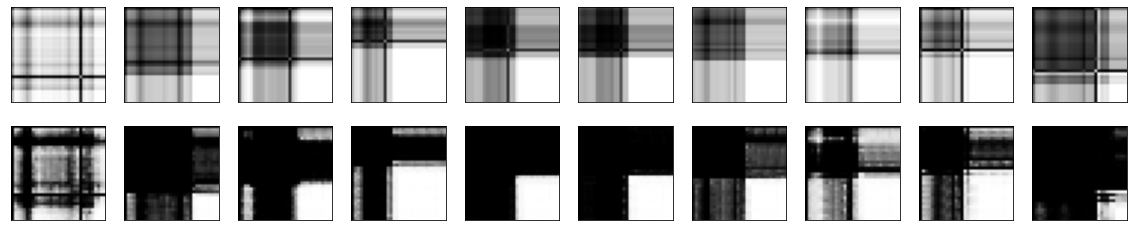

In [153]:

# 1행 Normal 원본 데이터
# 2행 Normal Reconstructed Data

n = 10 # 이미지 개수 
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    ax = plt.subplot(2,n,i)
    plt.imshow(np.transpose(test_normal_dataset[i][0],(1,2,0)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
     # 재구성된 데이터
    ax = plt.subplot(2, n, i + n)
    plt.imshow(np.transpose(model(test_normal_dataset[i][0]).detach(),(1,2,0)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
               

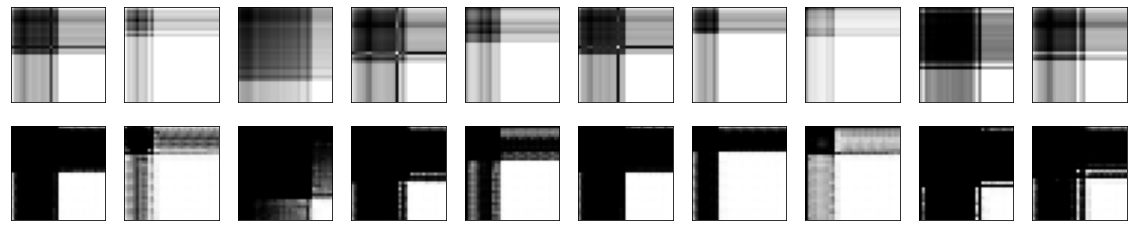

In [154]:
# 1행 abNormal 원본 데이터
# 2행 abNormal Reconstructed Data

n = 10 # 이미지 개수 
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    ax = plt.subplot(2,n,i)
    plt.imshow(np.transpose(test_abnormal_dataset[i][0],(1,2,0)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
     # 재구성된 데이터
    ax = plt.subplot(2, n, i + n)
    plt.imshow(np.transpose(model(test_abnormal_dataset[i][0]).detach(),(1,2,0)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# Threshold 정의

In [159]:
# Normal 데이터에 대한 재복원 오차

test_normal_loss = 0
for i in range(len(test_normal_dataset)):
    outputs = model(test_normal_dataset[i][0])
    test_normal_loss += criterion(outputs, test_normal_dataset[i][0])
    
Reconsturction_Error_normal_Dataset = test_normal_loss/len(test_normal_dataset)

In [157]:
# Abnormal 데이터에 대한 재복원 오차

test_abnormal_loss = 0
for i in range(len(test_abnormal_dataset)):
    outputs = model(test_abnormal_dataset[i][0])
    test_abnormal_loss += criterion(outputs, test_abnormal_dataset[i][0])
    
Reconsturction_Error_Abnormal_Dataset = test_abnormal_loss/len(test_abnormal_dataset)

In [160]:
# Normal 데이터에 대한 재복원 오차
Reconsturction_Error_normal_Dataset

tensor(1.4838, grad_fn=<DivBackward0>)

In [158]:
# Abnormal 데이터에 대한 재복원 오차
Reconsturction_Error_Abnormal_Dataset 

tensor(2.5519, grad_fn=<DivBackward0>)

In [236]:
# Threshold를 Noraml 데이터와 Abnormal 데이터에 대한 평균으로 정의

Anomaly_Threshold = (Reconsturction_Error_normal_Dataset + Reconsturction_Error_Abnormal_Dataset)/2

# Experiment

## Anomlay_Threshold를 Noraml 데이터와 Abnormal 데이터에 대한 평균으로 정의했을 때의 성능평가 지표

In [166]:
Predict_label = []
True_label = []
for i in range(len(test_normal_dataset)):
    outputs = model(test_normal_dataset[i][0])
    test_normal_loss = criterion(outputs, test_normal_dataset[i][0])
    if test_normal_loss < Anomaly_Threshold:
        Predict_label.append(0)
    else:
        Predict_label.append(1)
    True_label.append(0)

In [167]:
for i in range(len(test_abnormal_dataset)):
    outputs = model(test_abnormal_dataset[i][0])
    test_abnormal_loss = criterion(outputs, test_abnormal_dataset[i][0])
    if test_abnormal_loss < Anomaly_Threshold:
        Predict_label.append(0)
    else:
        Predict_label.append(1)
    True_label.append(1)

In [171]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns

[[2771  853]
 [1562 2212]]
0.6735604217356043
0.7216965742251223
0.5861155272919979
0.646878198567042


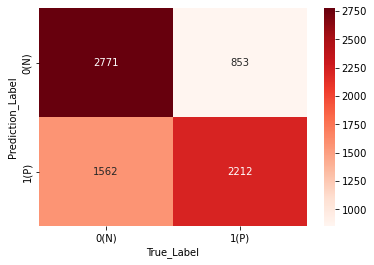

In [176]:
# Confusion Matrix 
# Positive = Abnormal, Negative = Normal

cm2 = confusion_matrix(True_label, Predict_label)
sns.heatmap(cm2, annot = True, fmt = 'd',cmap = 'Reds')
plt.xlabel('True_Label')
plt.ylabel('Prediction_Label')
plt.xticks([0.5,1.5],['0(N)', '1(P)'])
plt.yticks([0.5,1.5],['0(N)', '1(P)'])
plt.show()

In [177]:
# Accuracy_Score

print('Accuracy_Score', accuracy_score(True_label, Predict_label))

Accuracy_Score 0.6735604217356043


In [178]:
# Precision_Score

print('Precision_Score', precision_score(True_label, Predict_label))

Precision_Score 0.7216965742251223


In [179]:
# Recall_Score

print('Recall_Score', recall_score(True_label, Predict_label))

Recall_Score 0.5861155272919979


In [180]:
# F1_Score

print('F1_Score', f1_score(True_label, Predict_label))

F1_Score 0.646878198567042


## Anomlay_Threshold를 Noraml 데이터와 Abnormal 데이터에 대한 평균보다 0.1 크게 했을 때의 성능지표

In [ ]:
# Anomaly_Threshold 

In [182]:
Predict_label = []
True_label = []
for i in range(len(test_normal_dataset)):
    outputs = model(test_normal_dataset[i][0])
    test_normal_loss = criterion(outputs, test_normal_dataset[i][0])
    if test_normal_loss < Anomaly_Threshold+0.1:
        Predict_label.append(0)
    else:
        Predict_label.append(1)
    True_label.append(0)

In [183]:
for i in range(len(test_abnormal_dataset)):
    outputs = model(test_abnormal_dataset[i][0])
    test_abnormal_loss = criterion(outputs, test_abnormal_dataset[i][0])
    if test_abnormal_loss < Anomaly_Threshold+0.1:
        Predict_label.append(0)
    else:
        Predict_label.append(1)
    True_label.append(1)

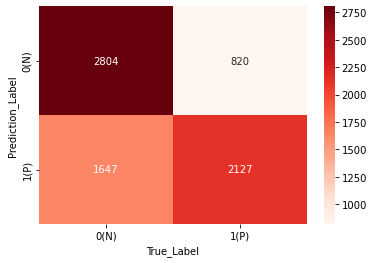

In [184]:
# Confusion Matrix 
# Positive = Abnormal, Negative = Normal

cm2 = confusion_matrix(True_label, Predict_label)
sns.heatmap(cm2, annot = True, fmt = 'd',cmap = 'Reds')
plt.xlabel('True_Label')
plt.ylabel('Prediction_Label')
plt.xticks([0.5,1.5],['0(N)', '1(P)'])
plt.yticks([0.5,1.5],['0(N)', '1(P)'])
plt.show()

In [185]:
# Accuracy_Score

print('Accuracy_Score', accuracy_score(True_label, Predict_label))

Accuracy_Score 0.6665314949986483


In [186]:
# Precision_Score

print('Precision_Score', precision_score(True_label, Predict_label))

Precision_Score 0.7217509331523583


In [187]:
# Recall_Score

print('Recall_Score', recall_score(True_label, Predict_label))

Recall_Score 0.5635930047694754


In [188]:
# F1_Score

print('F1_Score', f1_score(True_label, Predict_label))

F1_Score 0.6329415265585479


## Anomlay_Threshold를 Noraml 데이터와 Abnormal 데이터에 대한 평균보다 0.1 작게 했을 때의 성능지표

In [189]:
Predict_label = []
True_label = []
for i in range(len(test_normal_dataset)):
    outputs = model(test_normal_dataset[i][0])
    test_normal_loss = criterion(outputs, test_normal_dataset[i][0])
    if test_normal_loss < Anomaly_Threshold-0.1:
        Predict_label.append(0)
    else:
        Predict_label.append(1)
    True_label.append(0)

In [190]:
for i in range(len(test_abnormal_dataset)):
    outputs = model(test_abnormal_dataset[i][0])
    test_abnormal_loss = criterion(outputs, test_abnormal_dataset[i][0])
    if test_abnormal_loss < Anomaly_Threshold-0.1:
        Predict_label.append(0)
    else:
        Predict_label.append(1)
    True_label.append(1)

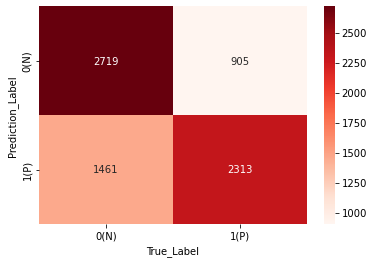

In [191]:
# Confusion Matrix 
# Positive = Abnormal, Negative = Normal

cm2 = confusion_matrix(True_label, Predict_label)
sns.heatmap(cm2, annot = True, fmt = 'd',cmap = 'Reds')
plt.xlabel('True_Label')
plt.ylabel('Prediction_Label')
plt.xticks([0.5,1.5],['0(N)', '1(P)'])
plt.yticks([0.5,1.5],['0(N)', '1(P)'])
plt.show()

In [192]:
# Accuracy_Score

print('Accuracy_Score', accuracy_score(True_label, Predict_label))

Accuracy_Score 0.680183833468505


In [193]:
# Precision_Score

print('Precision_Score', precision_score(True_label, Predict_label))

Precision_Score 0.718769422001243


In [194]:
# Recall_Score

print('Recall_Score', recall_score(True_label, Predict_label))

Recall_Score 0.6128775834658188


In [195]:
# F1_Score

print('F1_Score', f1_score(True_label, Predict_label))

F1_Score 0.6616132723112129


## Anomlay_Threshold를 Noraml 데이터와 Abnormal 데이터에 대한 평균보다 0.2 작게 했을 때의 성능지표

In [ ]:
Predict_label = []
True_label = []
for i in range(len(test_normal_dataset)):
    outputs = model(test_normal_dataset[i][0])
    test_normal_loss = criterion(outputs, test_normal_dataset[i][0])
    if test_normal_loss < Anomaly_Threshold-0.2:
        Predict_label.append(0)
    else:
        Predict_label.append(1)
    True_label.append(0)

In [197]:
for i in range(len(test_abnormal_dataset)):
    outputs = model(test_abnormal_dataset[i][0])
    test_abnormal_loss = criterion(outputs, test_abnormal_dataset[i][0])
    if test_abnormal_loss < Anomaly_Threshold-0.2:
        Predict_label.append(0)
    else:
        Predict_label.append(1)
    True_label.append(1)

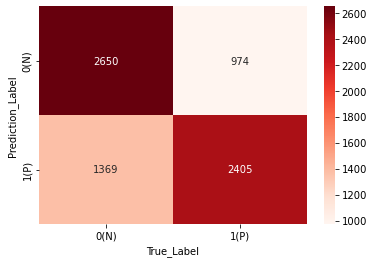

In [198]:
# Confusion Matrix 
# Positive = Abnormal, Negative = Normal

cm2 = confusion_matrix(True_label, Predict_label)
sns.heatmap(cm2, annot = True, fmt = 'd',cmap = 'Reds')
plt.xlabel('True_Label')
plt.ylabel('Prediction_Label')
plt.xticks([0.5,1.5],['0(N)', '1(P)'])
plt.yticks([0.5,1.5],['0(N)', '1(P)'])
plt.show()

In [199]:
# Accuracy_Score

print('Accuracy_Score', accuracy_score(True_label, Predict_label))

Accuracy_Score 0.6832927818329279


In [200]:
# Precision_Score

print('Precision_Score', precision_score(True_label, Predict_label))

Precision_Score 0.7117490381769754


In [201]:
# Recall_Score

print('Recall_Score', recall_score(True_label, Predict_label))

Recall_Score 0.6372549019607843


In [202]:
# F1_Score

print('F1_Score', f1_score(True_label, Predict_label))

F1_Score 0.6724451279183559


# 결과

-> Threshold가 낮아짐에 따라 성능평가지표가 상대적으로 높아지는 것을 확인할 수 있다.

Anomaly Detection 모델을 구성할 때는 Threshold의 설정이 굉장히 중요함을 추론할 수 있다. 